# PUMP IT UP




![Image](http://drivendata.materials.s3.amazonaws.com/pumps/pumping.jpg)

Using the data gathered from Taarifa and the Tanzanian Ministry of Water, can we predict which pumps are functional, which need some repairs, and which don't work at all? Predicting one of these three classes based and a smart understanding of which waterpoints will fail, can improve the maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

This is also an intermediate-level competition by [DataDriven][1]!



[1]: https://www.drivendata.org/competitions/7/ "Link to Competetion Page"


* [Git Hub Repo](https://github.com/msampathkumar/datadriven_pumpit)
* [Git Hub Report](https://github.com/msampathkumar/datadriven_pumpit/blob/master/capstone_proposal.mdown)
* [Features Details](https://www.drivendata.org/competitions/7/page/25/)


TODO:

1. Variance Threshold Dict
2. know variance threshold for removed columns in 


# Imports

In [61]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
%load_ext writeandexecute


plt.style.use('ggplot')
sns.set(color_codes=True)

# seed
np.random.seed(69572)

# plt.figure(figsize=(120,10))
small = (4,3)
mid = (10, 8)
large = (12, 8)

The writeandexecute extension is already loaded. To reload it, use:
  %reload_ext writeandexecute


In [62]:
import sys
sys.path = sys.path + ['/Users/sampathkumarm/Desktop/devbox/Sam-DS/Kaggle/datadriven']

from sam_value_counts import sam_dataframe_cols_value_count_analysis, sam_dataframe_markup_value_counts
from sam_confusion_matrix import sam_plot_confusion_matrix, sam_confusion_maxtrix

In [68]:
from __future__ import absolute_import
from IPython.core.getipython import get_ipython
from IPython.core.magic import (Magics, magics_class,  cell_magic)
import sys
from StringIO import StringIO
from markdown import markdown
from IPython.core.display import HTML

@magics_class
class MarkdownMagics(Magics):
 
    @cell_magic
    def asmarkdown(self, line, cell):
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
    
    def timer_message(self, start_time):
#         print self
        time_diff = (now() - start_time).total_seconds()
        if time_diff < 0.001:
            time_diff = 0
            print('\n<pre>In', time_diff, 'Secs</pre>')
        else:
            print('\n<pre>In', time_diff, 'Secs</pre>')

    @cell_magic
    def timer(self, line, cell):
        import datetime
        now = datetime.datetime.now
        start_time = now()
        buffer = StringIO()
        stdout = sys.stdout
        sys.stdout = buffer
        try:
            exec(cell, locals(), self.shell.user_ns)
            self.timer_message(start_time)
        except:
            sys.stdout = stdout
            raise
        sys.stdout = stdout
        return HTML("<p>{}</p>".format(markdown(buffer.getvalue(), extensions=['markdown.extensions.extra'])))
        return buffer.getvalue() + 'test'
 
get_ipython().register_magics(MarkdownMagics)

# Data Analysis

In [ ]:
RAW_X = pd.read_csv('traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('test_set_values.csv', index_col='id')

In [ ]:
len(RAW_X.columns)

In [ ]:
cols_ints = '''amount_tsh
gps_height
longitude
latitude
num_private
region_code
district_code
population
construction_year'''.splitlines()

cols_bool = 'public_meeting permit'.split()

cols_date = ['date_recorded']

print ('INT COlS: ', len(cols_ints))
print ('BOOL COLS:', len(cols_bool))
print ('BOOL COLS:', len(cols_date))

In [ ]:
(RAW_TEST_X[cols_ints]).dtypes

In [ ]:
(RAW_TEST_X[cols_bool + cols_bool]).dtypes # Needs a check

In [ ]:
RAW_TEST_X.describe()

In [ ]:
RAW_X.head().T

### cols_values_counts_dataframe

As we can see in above *describe* output, we seem to have lots of categorical values so let start exploring them a bit.

Lets start taking into believe everything is a Categorical Columns and check their data

In [ ]:
columns = RAW_X.columns
values_counts_bag = [len(RAW_X[column].value_counts()) for column in columns]

In [ ]:
cols_values_counts_dataframe = pd.DataFrame(np.log(values_counts_bag), index=columns, columns=['Value Counts'])

cols_values_counts_dataframe.T

** Example of how np-log transforms data**

    >>> np.log([0.001, 0.01, 0.1, 1, 10, 100, 1000])

    array([-6.90775528, -4.60517019, -2.30258509,  0.        ,  2.30258509,
            4.60517019,  6.90775528])

As you can see in np-log example, we can learn that when a list of values vary significantly(exponentially) then their logarithms moves linearly. As we(I) feel comfortable in studying linear plot and linear information, we did a np.log to values counts.

In [ ]:
print('Values Counts:', values_counts_bag)

print('\nLog of Values Counts:', np.log(values_counts_bag))

_ = sns.distplot(values_counts_bag, hist=True, kde=False,)

In [ ]:
cols_values_counts_dataframe.plot(kind='barh', figsize=(12, 12))
_ = plt.plot((2, 2), (0, 38))
_ = plt.plot((4, 4), (0, 38), '-g')
_ = plt.plot((6, 6), (0, 38), '-r')
print('We seem to have some special categories where value counts are high.')

In [ ]:
sam_dataframe_cols_value_count_analysis(RAW_X)

** Checking Rest of other columns**

In [ ]:
cols_value_count_limit_fraction = 0.01
cols_value_count_limit_log_value = np.log(RAW_X.shape[0] * cols_value_count_limit_fraction)


print('Total Number of Records:', RAW_X.shape[0], '- Log val is:', np.log(RAW_X.shape[0]))
print('%s percent of Number of Records:' % (cols_value_count_limit_fraction * 100),\
      RAW_X.shape[0] * cols_value_count_limit_fraction,\
      ' - Log val is:',  cols_value_count_limit_log_value)

### cols_categorical_check

Here in this project, cols categorical check refers to caution check on too much variety. Reason for this check is we would need more data to explain other columns & target cols with respect to it.

Lets consider these columns with more 5% of values as non categorical values and since our problem statement is choosing which category, we will try to minimise the category and see how our performance changes(improves or not)

To begin we will consider that those categories with more than `cols_value_count_limit_fraction` percentage as the upper limit allowed. Any column with other data will pruged to become some to other information

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

def show_object_dtypes(others=True):
    dtype = object
    if others:
        display(RAW_X.dtypes[RAW_X.dtypes != dtype])
    else:
        display(RAW_X.dtypes[RAW_X.dtypes == dtype])
    

_ = interact(show_object_dtypes, other=True);

In [ ]:
_ = interact(show_object_dtypes, other=False);

In [ ]:
cols_non_categorical = RAW_X.dtypes[RAW_X.dtypes == object].index.tolist()

cols_date_numerics = RAW_X.dtypes[RAW_X.dtypes != object].index.tolist()

In [ ]:
cols_categorical_check = []

for col, vc in cols_values_counts_dataframe.iterrows():
    if col in cols_non_categorical:
        if float(vc) > cols_value_count_limit_log_value:
            cols_categorical_check.append(col)

print('Columns we need to moderate are:', cols_categorical_check)

All cols_date_numerics, are date & other numeric data which can be made into buckets or reducing precision. Thus we can bound number of categories in data as the more variety of data we have, we need more information specific to each category which all might end with **curse of dimensionality**.

During pre-processing states we shall do following
TODO
* limiting check experiments on our **`cols_date_numerics`** & **`cols_categorical_check`** to be under **`cols_value_count_limit_fraction`**

In [ ]:
print (cols_value_count_limit_log_value, cols_value_count_limit_fraction * RAW_X.shape[0])

RAW_X[cols_categorical_check].head()

In [ ]:
_ = sns.distplot(RAW_X.gps_height, hist=True, kde=False, rug=False)

In [ ]:
_ = sns.distplot(RAW_X.population, hist=True, kde=False, rug=False)

In [ ]:
_ = sns.jointplot(x='longitude', y='latitude', data=RAW_X)

# Observations & TODO

* Most of the data seems categorical

* Need to check **cols_date_numerics**(TODO1)
    * we shall convert date -> day, month, year, weekday, total_no_of_day_from_reference_point. These splits for two reasons.
        * Reason1: It might be possible that in some location all specific set of complaints are registered on a start/mid/at end of the month. It might also be possible that they are registered on every Monday or so.
        * Reason2: Taking as much information as possible.
* Need to check **cols_categorical_check**(TODO2) 
    * longitutude & latitude seem to hold (0,0) instead of NULL which is acting as outlier for now

* Following pairs looks closesly related - cleanup (TODO3)
    * quantity & quantity_group
    * quality_group & water_quality
    * extraction_type, extraction_type_class & extraction_type_group

* Other - cleanup (TODO4)
    * recorded_by, seems to hold only a single value
    * population & amount_tsh, values are for some given as zero

In [ ]:
# %%asmarkdown
# # To generate a Markup Table
# tmp = sam_dataframe_markup_value_counts(dataframe=RAW_X, max_print_value_counts=10, show_plots=False, figsize=(9, 2))

# Data Processing

** Num/Bool Tranformations **

* date_recorded --> Int
* longitude --> Float(less precision)
* latitude --> Float(less precision)
* public_meeting --> Bool
* permit --> Bool


Precision Description of Longititude and Latitude is available here at below link.
* http://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude

In [134]:
# Reloading the data

RAW_X = pd.read_csv('traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('test_set_values.csv', index_col='id')

In [135]:
import datetime

strptime = datetime.datetime.strptime

DATE_FORMAT = "%Y-%m-%d"
REFERENCE_DATE_POINT = strptime('2000-01-01', DATE_FORMAT)

if RAW_X.date_recorded.dtype == 'O':

    # convert it to datetime format
    f = lambda x: strptime(str(x), DATE_FORMAT)
    RAW_X.date_recorded = RAW_X.date_recorded.apply(f)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.apply(f)

    # week day
    f = lambda x: x.weekday()
    RAW_X['date_recorded_weekday'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_weekday'] = RAW_TEST_X.date_recorded.apply(f)

    # date
    f = lambda x: x.day
    RAW_X['date_recorded_date'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_date'] = RAW_TEST_X.date_recorded.apply(f)

    # month
    f = lambda x: x.month
    RAW_X['date_recorded_month'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_month'] = RAW_TEST_X.date_recorded.apply(f)

    # year
    f = lambda x: x.year
    RAW_X['date_recorded_year'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_year'] = RAW_TEST_X.date_recorded.apply(f)

    # total days
    f = lambda x: (x - REFERENCE_DATE_POINT).days
    RAW_X.date_recorded = RAW_X.date_recorded.apply(f)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.apply(f)

In [136]:
# Longitude & Latitude -- zero values fix

# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'latitude'][RAW_X.latitude < -1.0].values)

if not RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'].empty:
    RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X.latitude >= -1.0, u'latitude'] = _


# Filling Missing/OUTLIAR Values
_ = np.mean(RAW_X[u'longitude'][RAW_X[u'longitude'] > 1.0].values)

if not RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'].empty:
    RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'] = _
    RAW_TEST_X.loc[RAW_TEST_X[u'longitude'] <= 1.0, u'longitude'] = _

In [137]:
RAW_TEST_X.public_meeting.value_counts()

True     12738
False     1291
Name: public_meeting, dtype: int64

In [138]:
def f(x):
    if x is True:
        return 1
    elif x is False:
        return 2
    else:
        return 3


if (RAW_X.public_meeting.dtype != 'bool') and (RAW_X.permit.dtype != 'bool'):

    # public_meeting
    RAW_X.public_meeting = RAW_X.public_meeting.apply(f)
    RAW_TEST_X.public_meeting = RAW_TEST_X.public_meeting.apply(f)

    # permit
    RAW_X.permit = RAW_X.permit.apply(f)
    RAW_TEST_X.permit = RAW_TEST_X.permit.apply(f)

print('Dtype of public_meetings & permit:',RAW_X.public_meeting.dtype, RAW_X.permit.dtype)
print()
# checking
if list(RAW_TEST_X.dtypes[RAW_TEST_X.dtypes != RAW_X.dtypes]):
    raise Exception('RAW_X.dtypes and RAW_TEST_X.dtypes are not in Sync')
else:
    print('All in Good Shape')

Dtype of public_meetings & permit: int64 int64

All in Good Shape


In [139]:
_ = interact(show_object_dtypes, other=True);

amount_tsh               float64
date_recorded              int64
gps_height                 int64
longitude                float64
latitude                 float64
num_private                int64
region_code                int64
district_code              int64
population                 int64
public_meeting             int64
permit                     int64
construction_year          int64
date_recorded_weekday      int64
date_recorded_date         int64
date_recorded_month        int64
date_recorded_year         int64
dtype: object

In [140]:
# Reducing geo location precision to 11 meters
LONG_LAT_PRECISION = 0.001

# Reducing Precision of Lat.
if RAW_X.longitude.mean() < 50:
    RAW_X.longitude = RAW_X.longitude // LONG_LAT_PRECISION
    RAW_X.latitude = RAW_X.latitude // LONG_LAT_PRECISION
    RAW_TEST_X.longitude = RAW_TEST_X.longitude // LONG_LAT_PRECISION
    RAW_TEST_X.latitude = RAW_TEST_X.latitude // LONG_LAT_PRECISION

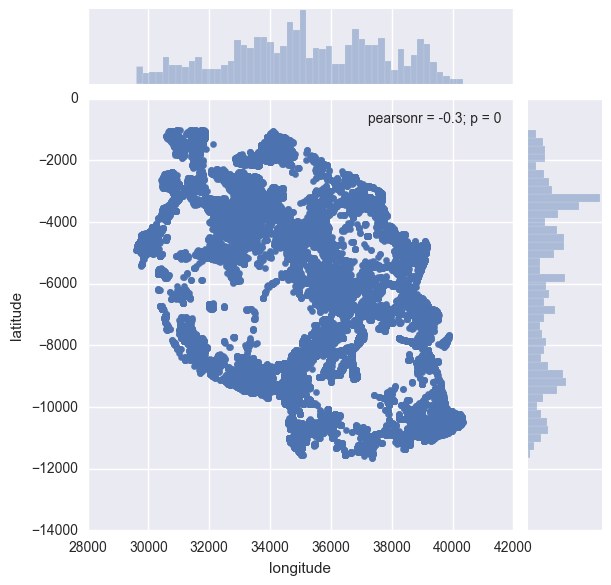

In [141]:
_ = sns.jointplot(x='longitude', y='latitude', data=RAW_X)

** Text Data Tranformations **

For **cols_categorical_check**, we are going to basic clean action like, lower and upper case issue. Clearning of non ascii values.

In [142]:
def text_transformation(name):
    if name:
        name = name.lower().strip()
        name = ''.join([i if 96 < ord(i) < 128 else ' ' for i in name])
        if 'and' in name:
            name = name.replace('and', ' ')
        if '/' in name:
            name = name.replace('/', ' ')
        while '  ' in name:
            name = name.replace('  ', ' ')
        return name.strip()
    return ''

In [143]:
%%asmarkdown

print ('''
|Column|Prev.|Current|
|------|-----|-------|''')
for col in cols_categorical_check:
    aa = len(RAW_X[col].unique())
    RAW_X[col] = RAW_X[col].fillna('').apply(text_transformation)
    RAW_TEST_X[col] = RAW_TEST_X[col].fillna('').apply(text_transformation)
    bb = len(RAW_X[col].unique())
    if aa != bb:
        print ('|%s|%i|%i|' % (col, aa, bb))

Column,Prev.,Current
funder,1898,1880
installer,2146,1866
wpt_name,37400,36717
subvillage,19288,19175
scheme_name,2697,2485


In [144]:
labler = CUST_CATEGORY_LABELER()
labler.fit(RAW_X.funder)

# To check data coverage
def f(x=50):
    labler.check_data_coverage(data_coverage=x)

ii1 = interact(f, x=(50, 100, .5))

# To check groups coverage
def f(x=80):
    labler.check_group_coverage(x)
    
ii2 = interact(f, x=(80, 100., .5))

80.0 percentage of GROUPS coverage mean, 1504.0(in number) groups


In [145]:
from collections import defaultdict

import helper
reload(helper)

CUST_CATEGORY_LABELER = helper.CUST_CATEGORY_LABELER

In [146]:
for col in ['funder', 'installer', 'wpt_name', 'subvillage', 'ward', 'scheme_name']:
    labler = custom_labler[col]
    labler.fit(RAW_X[col])
    print ('==' * 5, col)
#     RAW_X[col] = labler.transform()
    custom_labler[col].check_data_coverage(80)

========== funder
80 percentage of DATA coverage mean, 97 (in number) groups
========== installer
80 percentage of DATA coverage mean, 81 (in number) groups
========== wpt_name
80 percentage of DATA coverage mean, 24838 (in number) groups
========== subvillage
80 percentage of DATA coverage mean, 8567 (in number) groups
========== ward
80 percentage of DATA coverage mean, 998 (in number) groups
========== scheme_name
80 percentage of DATA coverage mean, 348 (in number) groups


In [149]:
try:
    drop_cols = ['wpt_name',]
    if drop_cols:
        RAW_X.drop(drop_cols, axis=1, inplace=True)
        RAW_TEST_X.drop(drop_cols, axis=1, inplace=True)
        print('Dropped Cols')
except ValueError:
    if not all(map(lambda x: x in RAW_X.columns, drop_cols)):
        print('Drop cols is already done')

Drop cols is already done


In [150]:
RAW_X.shape, RAW_TEST_X.shape, all(RAW_X.columns == RAW_TEST_X.columns)

((59400, 42), (14850, 42), True)

## Label Encoder

Label Encoder with DefaultDict for quick data transformation
http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

In [151]:
from collections import defaultdict
from sklearn import preprocessing

In [152]:
print(RAW_X.shape, RAW_TEST_X.shape)

(59400, 42) (14850, 42)


In [153]:
RAW_X.dtypes

amount_tsh               float64
date_recorded              int64
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting             int64
recorded_by               object
scheme_management         object
scheme_name               object
permit                     int64
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_quality             object
quality_gr

In [154]:
d = defaultdict(preprocessing.LabelEncoder)

# Labels Fit
sam = pd.concat([RAW_X, RAW_TEST_X]).apply(lambda x: d[x.name].fit(x))

# Labels Transform - Training Data
X = RAW_X.apply(lambda x: d[x.name].transform(x))
TEST_X = RAW_TEST_X.apply(lambda x: d[x.name].transform(x))

le = preprocessing.LabelEncoder().fit(RAW_y[u'status_group'])
y = le.transform(RAW_y[u'status_group'])

/Users/sampathkumarm/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [155]:
X.head(5)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,...,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,date_recorded_weekday,date_recorded_date,date_recorded_month,date_recorded_year
id,,,,,,,,,,,,,,,,,,,,,
69572,65,54,1538,1450,1534,5101,1479,0,1,13024,...,1,8,6,0,1,1,0,13,2,3
8776,0,322,517,1459,571,4861,8895,0,4,17503,...,2,5,3,1,1,1,2,5,2,5
34310,15,313,919,746,2049,7602,7358,0,5,10032,...,1,0,1,1,2,1,0,24,1,5
67743,0,285,1945,323,1891,8585,257,0,7,9938,...,0,3,0,0,2,1,0,27,0,5
19728,0,111,20,60,110,1385,9212,0,4,8497,...,3,5,3,1,1,1,2,12,6,3


## Pickle

** Pickle Save **

In [157]:
pickle.dump(X, open('X.pkl', 'w'))
pickle.dump(TEST_X, open('TEST_X.pkl', 'w'))

pickle.dump(y, open('y.pkl', 'w'))
pickle.dump(d, open('d.pkl', 'w'))
pickle.dump(le, open('le.pkl', 'w'))

** Pickle Load **

In [158]:
X = pickle.load(open('X.pkl'))
y = pickle.load(open('y.pkl'))

In [159]:
# Load this when you are about to do text transformation and submission

TEST_X = pickle.load(open('TEST_X.pkl'))
d = pickle.load(open('d.pkl'))
le = pickle.load(open('le.pkl'))

In [160]:
X.shape, y.shape

((59400, 42), (59400,))

In [161]:
y[:5]

array([0, 0, 0, 2, 0])

# Feature Selection


### Variance Threshold

To remove all features that are either one or zero (on or off) in more than 80% of the samples.

http://scikit-learn.org/stable/modules/feature_selection.html#removing-features-with-low-variance

http://stackoverflow.com/questions/29298973/removing-features-with-low-variance-scikit-learn/34850639#34850639

In [162]:
from sklearn.feature_selection import VarianceThreshold

def get_low_variance_columns(dframe=None, columns=[],
                             skip_columns=[], threshold=0.0,
                             autoremove=False):
    """
    Wrapper for sklearn VarianceThreshold for use on pandas dataframes.
    """
    print("Finding low-variance features.")
    removed_features = []
    ranking_variance_thresholds = {}
    try:
        # get list of all the original df columns
        all_columns = dframe.columns

        # remove `skip_columns`
        remaining_columns = all_columns.drop(skip_columns)

        # get length of new index
        max_index = len(remaining_columns) - 1

        # get indices for `skip_columns`
        skipped_idx = [all_columns.get_loc(col)
                       for col
                       in skip_columns]

        # adjust insert location by the number of columns removed
        # (for non-zero insertion locations) to keep relative
        # locations intact
        for idx, item in enumerate(skipped_idx):
            if item > max_index:
                diff = item - max_index
                skipped_idx[idx] -= diff
            if item == max_index:
                diff = item - len(skip_columns)
                skipped_idx[idx] -= diff
            if idx == 0:
                skipped_idx[idx] = item

        # get values of `skip_columns`
        skipped_values = dframe.iloc[:, skipped_idx].values

        # get dataframe values
        X = dframe.loc[:, remaining_columns].values

        # instantiate VarianceThreshold object
        vt = VarianceThreshold(threshold=threshold)

        # fit vt to data
        vt.fit(X)

        # threshold ranking
        ranking_variance_thresholds = dict(zip(remaining_columns, vt.variances_))

        # get the indices of the features that are being kept
        feature_indices = vt.get_support(indices=True)

        # remove low-variance columns from index
        feature_names = [remaining_columns[idx]
                         for idx, _
                         in enumerate(remaining_columns)
                         if idx
                         in feature_indices]

        # get the columns to be removed
        removed_features = list(np.setdiff1d(remaining_columns,
                                             feature_names))
        print("Found {0} low-variance columns."
              .format(len(removed_features)))

        # remove the columns
        if autoremove:
            print("Removing low-variance features.")
            # remove the low-variance columns
            X_removed = vt.transform(X)

            print("Reassembling the dataframe (with low-variance "
                  "features removed).")
            # re-assemble the dataframe
            dframe = pd.DataFrame(data=X_removed,
                                  columns=feature_names)

            # add back the `skip_columns`
            for idx, index in enumerate(skipped_idx):
                dframe.insert(loc=index,
                              column=skip_columns[idx],
                              value=skipped_values[:, idx])
            print("Succesfully removed low-variance columns.")

        # do not remove columns
        else:
            print("No changes have been made to the dataframe.")

    except Exception as e:
        print(e)
        print("Could not remove low-variance features. Something "
              "went wrong.")
        return dframe, [], {}

    return dframe, removed_features, ranking_variance_thresholds

In [164]:
X, removed_features, ranking_variance_thresholds = get_low_variance_columns(dframe=X,
                                                                            threshold=(0.85 * (1 - 0.85)),
                                                                            autoremove=True)

print('\nLow Variance Columns', removed_features)
print('Shape of X is', X.shape)

Finding low-variance features.
Found 1 low-variance columns.
Removing low-variance features.
Reassembling the dataframe (with low-variance features removed).
Succesfully removed low-variance columns.

Low Variance Columns ['recorded_by']
Shape of X is (59400, 41)


In [165]:
TEST_X.drop(removed_features, axis=1, inplace=True)

In [167]:
print('Shape of X is', X.shape)
print('Shape of TEST_X is', TEST_X.shape)

Shape of X is (59400, 41)
Shape of TEST_X is (14850, 41)


### Select K Best

* For regression: f_regression, mutual_info_regression
* For classification: chi2, f_classif, mutual_info_classif


Random Forest Classifier score: RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1)
* chi2 0.81225589225589223
*  f_classic 0.81138047138047142
* mutual_info_classif 0.81037037037037041

In [168]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

In [ ]:
K_BEST_COLS = 30

fit = SelectKBest(score_func=chi2, k=K_BEST_COLS).fit(X, y)
cols_names = X.columns

np.set_printoptions(precision=2)

ranking_selectkbest = dict(zip(cols_names, fit.scores_))
selected_cols =  [_ for _ in cols_names[:K_BEST_COLS]]

In [ ]:
print 'Removed Columns:\n\t', '\t'.join([ _ for _ in X.columns if _ not in selected_cols ])
selected_cols.sort()
print '\nSelected Columns:\n\t', '\n\t'.join(selected_cols)

In [ ]:
features = pd.DataFrame(fit.transform(X))
features.columns = selected_cols

In [ ]:
# % pprint
ranking_selectkbest

In [ ]:
print X.shape, features.shape, len(y)

In [ ]:
print X.shape, features.shape

In [ ]:
X = pd.DataFrame(fit.transform(X))
X.columns = selected_cols

print

# TEST_X = pd.DataFrame(fit.transform(TEST_X))
# TEST_X.columns = selected_cols

In [ ]:
TEST_X = pd.DataFrame(fit.transform(TEST_X))

print TEST_X.shape, X.shape

In [ ]:
pickle.dump(X, open('processed_X.pkl', 'w'))
pickle.dump(TEST_X, open('processed_TEST_X.pkl', 'w'))
pickle.dump(y, open('processed_y.pkl', 'w'))

### PCA

** Loading Pre-Processed Data **

In [ ]:
X = pickle.load(open('processed_X.pkl'))
TEST_X = pickle.load(open('processed_TEST_X.pkl'))
y = pickle.load(open('processed_y.pkl'))

** PCA **

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# feature extraction
pca = PCA(n_components=7)
fit = pca.fit(X)

In [ ]:
plt.figure(figsize=(12, 3))

_ = plt.scatter (range(len(fit.explained_variance_ratio_)), fit.explained_variance_ratio_.cumsum())

_ = plt.xlabel('cumsum of explained variance')

print fit.explained_variance_ratio_.cumsum()

In [ ]:
X = pca.transform(X)
TEST_X = pca.transform(TEST_X)

** Saving Processed Data **

In [ ]:
pickle.dump(X, open('processed_X.pkl', 'w'))
pickle.dump(TEST_X, open('processed_TEST_X.pkl', 'w'))
pickle.dump(y, open('processed_y.pkl', 'w'))

# Unsupervised Learning

* Unsupervised Learning Exploration(Gaussian Process, Neural Nets)

** Loading Pre-Processed Data **

In [ ]:
X = pickle.load(open('processed_X.pkl'))
TEST_X = pickle.load(open('processed_TEST_X.pkl'))
y = pickle.load(open('processed_y.pkl'))

In [ ]:
print X.shape, y.shape, TEST_X.shape

### Gaussian

In [ ]:
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

try:
    import renders as rs
except:
    print 'Not able to import renders'
    pass
import seaborn as sb
from IPython.display import display

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score

In [ ]:
# For future analysis
GMM_Centers = []

__check_for  = 1000

for i in range(2, 7):
    # TODO: Apply your clustering algorithm of choice to the reduced data 
    clusterer = GMM(n_components=i, random_state=42)
    clusterer.fit(X)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(X)

    # TODO: Find the cluster centers
    GMM_Centers.append(clusterer.means_)

    # score = silhouette_score(X, preds)
    score = silhouette_score(X[:__check_for], preds[:__check_for])

    print i, score

### KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# For future analysis
KMM_Centers = []

# Testing each category
for i in range(2, 7):

    clusterer = KMeans(init='k-means++', n_clusters=i, n_init=10)
    clusterer.fit(X)

    preds = clusterer.predict(X)

    centers = clusterer.cluster_centers_
    
    KMM_Centers.append(centers)

#     score = silhouette_score(X, preds)
    score = silhouette_score(X[:__check_for], preds[:__check_for])
    print i, score

In [ ]:
i = 2

clusterer = KMeans(init='k-means++', n_clusters=i, n_init=10)
clusterer.fit(X)
preds = clusterer.predict(X)

In [ ]:
score = silhouette_score(X[:__check_for], preds[:__check_for])
print i, score

In [ ]:
print X.shape, TEST_X.shape

In [ ]:
X = pd.DataFrame(X)
X['new'] = clusterer.predict(X)

In [ ]:
TEST_X = pd.DataFrame(TEST_X)
TEST_X['new'] = clusterer.predict(TEST_X)

In [ ]:
print X.shape, TEST_X.shape

# Supervised Learning

* Supervised Learning(GBT Trees, Nearest Neighbours, RF, One-vs-One)

### Test-Train Split

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# print features.shape
# X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.25, random_state=42, stratify=y)

### GBT Trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gbt_clf = GradientBoostingClassifier(n_estimators=150, max_depth=5)

In [ ]:
gbt_clf = gbt_clf.fit(X_train, y_train)

print 'score:', gbt_clf.score(X_test, y_test)

# score: 0.787272727273

### Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_clf = KNeighborsClassifier()

In [ ]:
knn_clf.fit(X_test, y_test)

In [ ]:
knn_clf.score(X_train, y_train)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1)
# class_weight="balanced_subsample"/"balanced"
# criterion="gini"/"entropy"

rf_clf = rf_clf.fit(X_train, y_train)
# pred = rf_clf.predict_proba(X_test)
rf_clf.score(X_test, y_test)

# (n_estimators=100, class_weight="balanced_subsample", n_jobs=-1) 0.80782828282828278
# (n_estimators=100, class_weight="balanced_subsample", n_jobs=-1) 0.81186868686868685
# (n_estimators=150, class_weight="balanced_subsample", n_jobs=-1) 0.8113636363636364

# (n_estimators=150, criterion='gini', class_weight="balanced_subsample", n_jobs=-1) 0.81018518518518523
# (n_estimators=150, criterion='gini', class_weight="balanced", n_jobs=-1) 0.80858585858585863
# (n_estimators=150, criterion='gini', n_jobs=-1) 0.80942760942760938
# (n_estimators=150, criterion='entropy', n_jobs=-1) 0.81060606060606055

# (n_estimators=10, criterion='gini', class_weight="balanced_subsample", n_jobs=-1) 0.79781144781144786
# (n_estimators=10, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1) 0.80185185185185182
# (n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1) 0.8113636363636364
# (n_estimators=150, criterion='gini', class_weight="balanced", n_jobs=-1) 0.80984848484848482

# (n_estimators=150, criterion='gini', class_weight="balanced", n_jobs=-1) 0.81259259259259264
# (n_estimators=150, criterion='gini', class_weight="balanced_subsample", n_jobs=-1) 0.81259259259259264
# (n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1) 0.81252525252525254

# 0.81198653198653203

### Multi Class

In [ ]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

** One Vs One **

In [ ]:
multiclass_rf_clf = OneVsOneClassifier(RandomForestClassifier(n_estimators=100,
                                                        criterion='entropy',
#                                                         class_weight="balanced_subsample",
                                                        n_jobs=-1))

# 0.81265993265993264

In [ ]:
multiclass_rf_clf = multiclass_rf_clf.fit(X_train, y_train)

print 'Classifier:', multiclass_rf_clf

print 'Score:', multiclass_rf_clf.score(X_test, y_test)

** One vs Rest **

In [ ]:
multiclass_rf_clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=200,
                                                        criterion='entropy',
                                                        class_weight="balanced_subsample",
                                                        n_jobs=-1))

# 0.81393939393939396

# 0.81272727272727274

# 0.81131313131313132

In [ ]:
multiclass_rf_clf = multiclass_rf_clf.fit(X_train, y_train)

print 'Classifier:', multiclass_rf_clf

print 'Score:', multiclass_rf_clf.score(X_test, y_test)

## Parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
parameters = {
    'n_estimators': [50, 100, 150],
    'class_weight': 'balanced_subsample balanced'.split(),
    'criterion': 'gini entropy'.split()
}
GS_CV = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, n_jobs=-1)
# GS_CV = RandomizedSearchCV(RandomForestClassifier(), parameters)

GS_CV.fit(X, y)

In [ ]:
print GS_CV.best_params_, GS_CV.best_score_

In [ ]:
for each in GS_CV.grid_scores_:
    print str(each).replace(' ', '')


* Checking "rf_clf" RF performance

In [ ]:
len(rf_clf.feature_importances_)

In [ ]:
plt.figure(figsize=(12, 3))

tmp = rf_clf.feature_importances_

# making importance relative
a, b = min(tmp), max(tmp)
cols_imp = (tmp - a) /b
_ = plt.scatter(range(len(cols_imp)), cols_imp)

# line plots
_ = plt.plot((0, len(cols_imp)), (0.25, 0.25), '-g')
_ = plt.plot((0, len(cols_imp)), (0.55, 0.55), '-b')
_ = plt.plot((0, len(cols_imp)), (0.75, 0.75), '-r')

_ = plt.xlabel('Columns')
_ = plt.ylabel('Relative Col Importance')

## XGBOOST

In [ ]:
import xgboost as xgb

In [ ]:
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.05).fit(X_train, y_train)

gbm_predictions = gbm.predict(X_test)

In [ ]:
print sum(gbm_predictions == y_test)/ (1.0 * len(y_test)) # 0.7279461279461279

# Submission

**Model Selection**

+ Check for which model is performing best and using it.
+ Check to apply the one-vs-many//one-vs-one wrapper.
+ Check for 'test_train_split' for which X,y to be used for training

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight="balanced_subsample", n_jobs=-1)

rf_clf = rf_clf.fit(X, y)

In [ ]:
# saving the index
test_ids = RAW_TEST_X.index

# predicint the values
predictions = clf.predict(TEST_X)
print (predictions.shape)

# Converting int to its respective Labels
predictions_labels = le.inverse_transform(predictions)

# setting up column name & save file
sub = pd.DataFrame(predictions_labels, columns=['status_group'])
sub.head()
sub.insert(loc=0, column='id', value=test_ids)
sub.reset_index()
sub.to_csv('submit.csv', index = False)
sub.head()